In [2]:
import torch
from scipy.sparse.linalg import LaplacianNd
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torchcfm.fourier_transform import NaiveGridFourierTransform, grid_laplacian_eigenpairs

# Compute the Laplacian and visualise eigenvectors

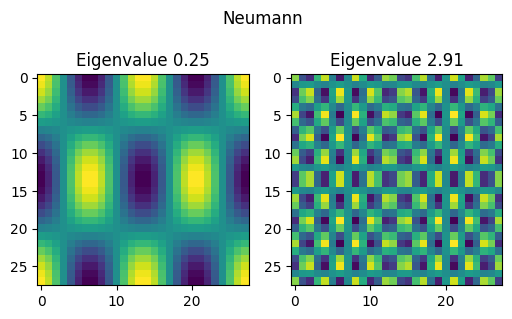

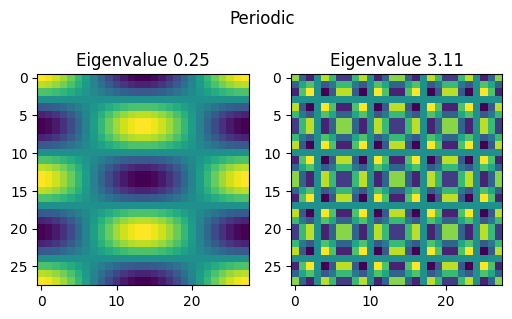

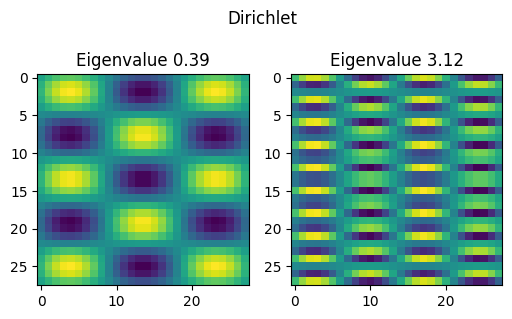

In [3]:
N_ROWS = 28
N_COLS = 28
BOUNDARY_CONDITIONS = ['neumann', 'periodic', 'dirichlet']
EIGENIDX = [20, 250]

for boundary_conditions in BOUNDARY_CONDITIONS:
    eigvecs, eigvals = grid_laplacian_eigenpairs((N_ROWS, N_COLS), boundary_conditions=boundary_conditions)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3.5))
    for ax, eigidx in zip(axs, EIGENIDX):
        c = eigvecs[:, eigidx].reshape(N_ROWS, N_COLS)
        ax.imshow(c)
        ax.set_title(f'Eigenvalue {eigvals[eigidx]:.2f}')
    fig.suptitle(boundary_conditions.capitalize())
    plt.show()

# MNIST fourier transform

In [14]:
trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32)), transforms.Normalize((0.5,), (0.5,))]),
)

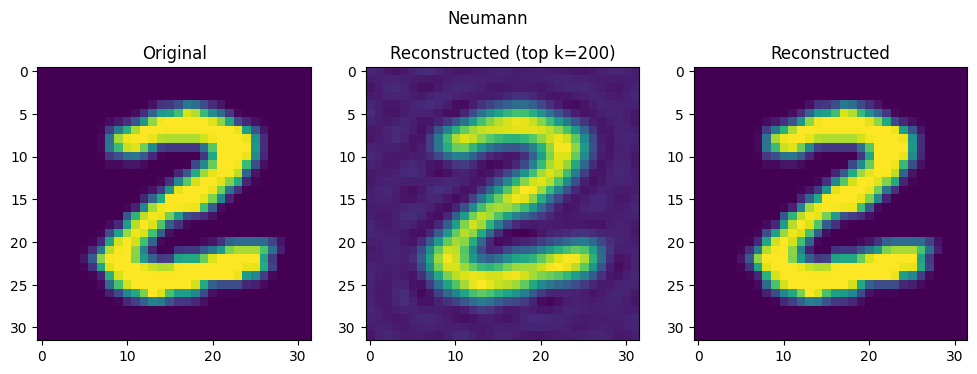

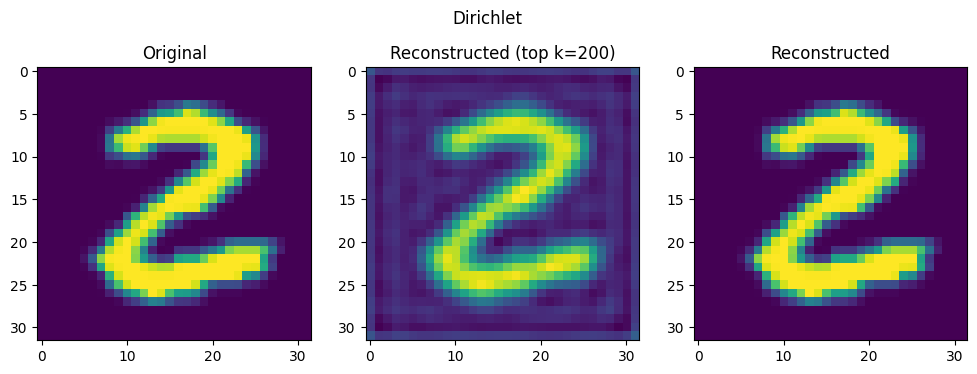

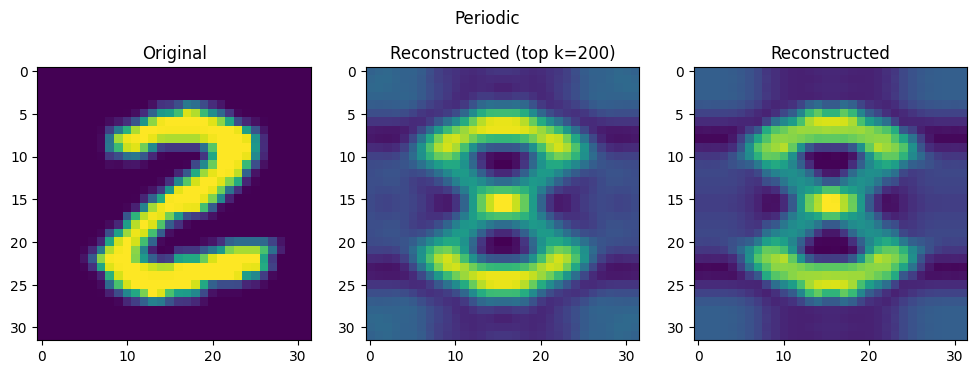

In [15]:
x = trainset[25][0][0]
shape = x.shape

for boundary_conditions in ['neumann', 'dirichlet', 'periodic']:
    k = 200

    eigvecs, eigvals = grid_laplacian_eigenpairs(shape, boundary_conditions=boundary_conditions)
    ft_full = NaiveGridFourierTransform(shape, eigvecs)
    ft_partial = NaiveGridFourierTransform(shape, eigvecs[:, :k])

    x_hat_partial = ft_partial.inverse_transform(ft_partial.transform(x))
    x_hat_full = ft_full.inverse_transform(ft_full.transform(x))

    U = eigvecs.mT[:k]
    x_hat_partial = (U.mT @ (U @ x.flatten())).reshape(32, 32)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x)
    axs[1].imshow(x_hat_partial)
    axs[2].imshow(x_hat_full)

    axs[0].set_title('Original')
    axs[1].set_title(f'Reconstructed (top {k=})')
    axs[2].set_title('Reconstructed')

    fig.suptitle(boundary_conditions.capitalize())

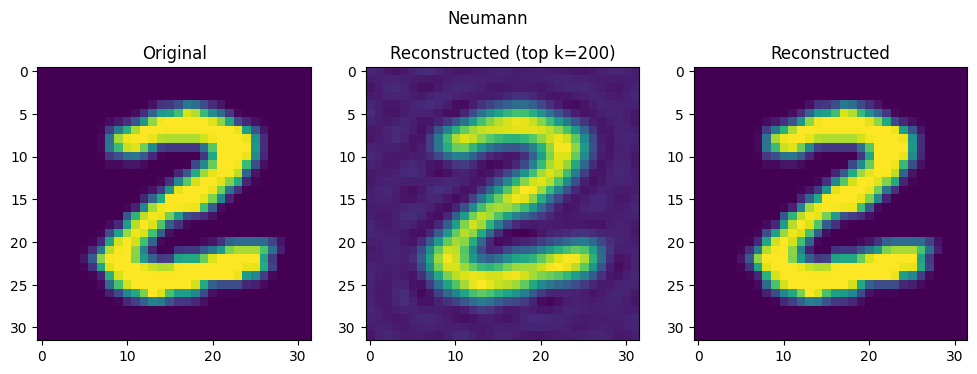

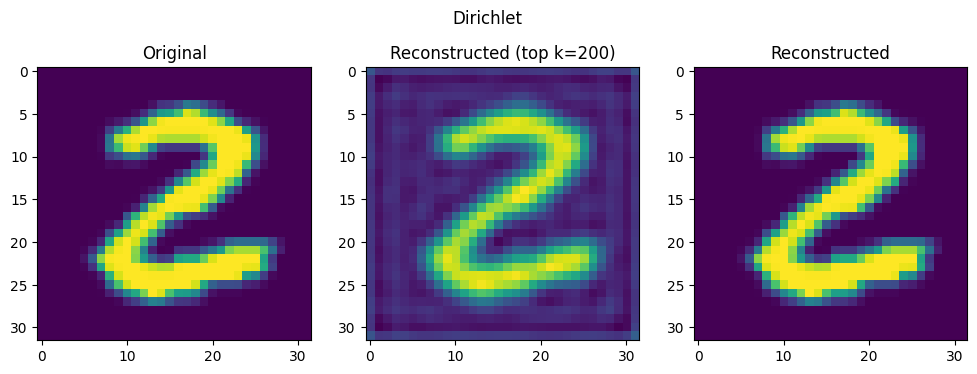

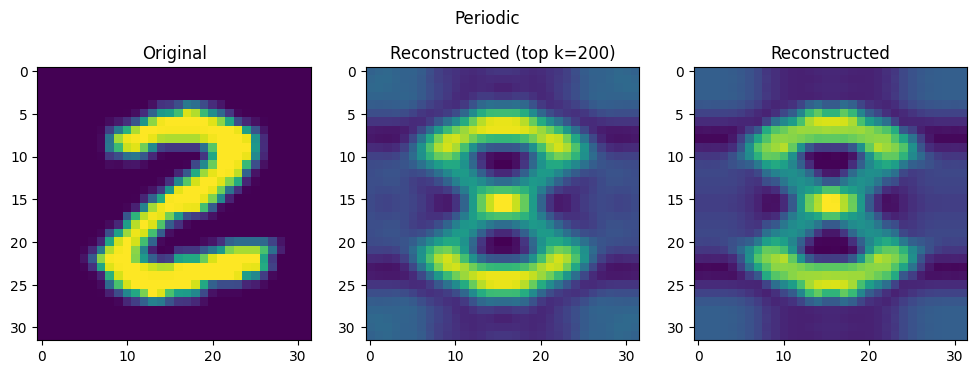

In [16]:
x = trainset[25][0][0]
shape = x.shape

for boundary_conditions in ['neumann', 'dirichlet', 'periodic']:
    k = 200

    eigvecs, eigvals = grid_laplacian_eigenpairs(shape, boundary_conditions=boundary_conditions)
    ft_full = NaiveGridFourierTransform(shape, eigvecs)
    ft_partial = NaiveGridFourierTransform(shape, eigvecs[:, :k])

    x_hat_partial = ft_partial.inverse_transform(ft_partial.transform(x))
    x_hat_full = ft_full.inverse_transform(ft_full.transform(x))

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x)
    axs[1].imshow(x_hat_partial)
    axs[2].imshow(x_hat_full)

    axs[0].set_title('Original')
    axs[1].set_title(f'Reconstructed (top {k=})')
    axs[2].set_title('Reconstructed')

    fig.suptitle(boundary_conditions.capitalize())

# Simplify $u$ expression

In [7]:
import sympy as sp


c, l, y0, y1, t = sp.symbols('c, l, y0, y1, t')

def sigma(t):
    return - (sp.exp(-2 * c * l * t) - 1) / (2 * c * l)

def m(t, y):
    return sp.exp(-c * l * t) * y

def my1(t, y):
    return m(t, y) + sp.exp(-c * l * (1 - t)) * sigma(t) / sigma(1) * (y1 - m(1, y0))


def u(t, y):
    return sp.exp(-c * l * (1 - t)) / sigma(1 - t) * (y1 - m(1 - t, y))

In [8]:
sp.simplify(my1(t, y0))

-(-y0*(exp(2*c*l) - 1) + (y0 - y1*exp(c*l))*(exp(2*c*l*t) - 1))*exp(-c*l*t)/(exp(2*c*l) - 1)

In [9]:
sp.simplify(u(t, my1(t, y0)))

-2*c*l*(y0 - y1*exp(c*l))*exp(c*l*t)/(exp(2*c*l) - 1)

# Verify implementation of ConditionalTopologicalFlowMatcher

## 2D example

In [10]:
from torchcfm.conditional_flow_matching import ConditionalTopologicalFlowMatcher
from torchcfm.fourier_transform import Naive1DFourierTransform
torch.set_default_dtype(torch.float64)



def euler_method(x0, vt, ts):
    dxts = torch.einsum('i..., i -> i...', vt[:-1], ts[1:] - ts[:-1])
    xts = x0.expand(ts.shape[0], *x0.shape).clone()
    xts[1:] += torch.cumsum(dxts, dim=0)
    return xts

In [11]:
eigvecs = torch.eye(2)
eigvals = torch.tensor([1.0, 1.0])
c = 2.0
ft = Naive1DFourierTransform(eigvecs)
cfm = ConditionalTopologicalFlowMatcher(c=c, eigenvalues=eigvals, eigenvectors=eigvecs, fourier_transform=ft)


n = 1000
x0 = torch.tensor([[2.0, -1.0]]).expand(n, -1)
x1 = torch.tensor([[4.0, 1.0]]).expand(n, -1)
t = torch.linspace(0.0, 1.0, n)

# spectral computations 
y0, y1 = ft.transform(x0), ft.transform(x1)
yt = cfm._bridge_m(y0, y1, t)
bt = cfm._b(yt, t)
ut = cfm._bridge_u(y0, y1, t, yt)
dyt = bt + ut 

yt_pred = euler_method(y0, dyt, t)
error = torch.norm(yt - yt_pred, dim=-1)


# Convert to standard coordinates
xt, xt_pred = ft.inverse_transform(yt), ft.inverse_transform(yt_pred)

RuntimeError: The size of tensor a (1000) must match the size of tensor b (999) at non-singleton dimension 1

ValueError: 'c' argument has 1000 elements, which is inconsistent with 'x' and 'y' with size 28000.

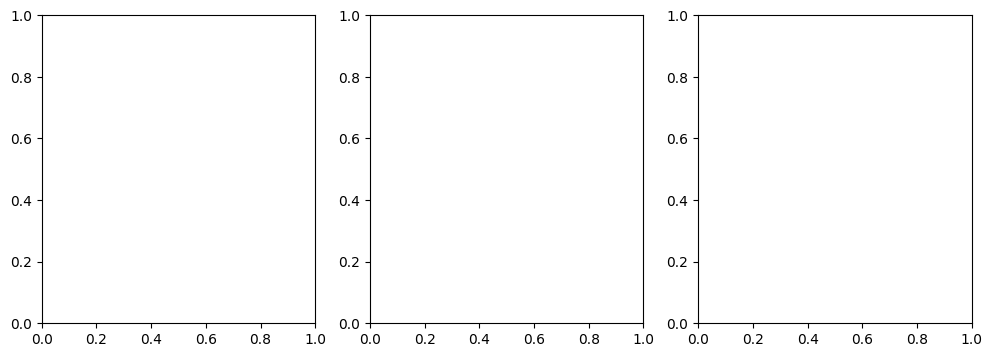

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(xt[:, 0], xt[:, 1], c=t, cmap='viridis', s=10.0)
# axs[0].quiver(xt[:, 0], xt[:, 1], vt[:, 0], vt[:, 1], scale=100, width=0.003, color='grey')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].scatter(xt_pred[:, 0], xt_pred[:, 1], c=t, cmap='viridis', s=10.0)
# axs[1].quiver(xt_pred[:, 0], xt_pred[:, 1], vt[:, 0], vt[:, 1], scale=100, width=0.003, color='grey')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[2].scatter(t, error, s=5.0)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Error')

axs[0].set_title('True path')
axs[1].set_title('Euler path')
axs[2].set_title('Error')


plt.tight_layout()

# Images

In [17]:
def heat_gp_sample(sample_shape: tuple[int, ...], input_shape: tuple[int, ...], eigvals: torch.Tensor, eigvecs: torch.Tensor, c: float) -> torch.Tensor:
    eps = torch.randn(sample_shape + eigvals.shape)
    spectral_density = torch.exp(-eigvals * c).sqrt()
    res = torch.einsum("kd, ...k -> ...d", eigvecs, eps * spectral_density)
    res = torch.reshape(res, sample_shape + input_shape)
    return res


class HeatGP:
    def __init__(self, eigvals: torch.Tensor, eigvecs: torch.Tensor, c: float, input_shape: tuple[int, ...]):
        self.eigvals = eigvals
        self.eigvecs = eigvecs.mT
        self.c = c
        self.input_shape = input_shape

    def sample(self, shape: tuple[int, ...] = torch.Size([])) -> torch.Tensor:
        return heat_gp_sample(shape, self.input_shape, self.eigvals, self.eigvecs, self.c)


def build_p0(name: str = 'normal', eigvals: torch.Tensor = None, eigvecs: torch.Tensor = None, c: float = None, input_shape: tuple[int, ...] = None) -> HeatGP | torch.distributions.Distribution:
    if name == 'gp':
        return HeatGP(eigvals, eigvecs, c, input_shape)
    elif name == 'normal':
        normal = torch.distributions.Normal(torch.zeros(*input_shape), torch.ones(*input_shape))
        return normal
    else:
        raise ValueError(f"Invalid name: {name}")

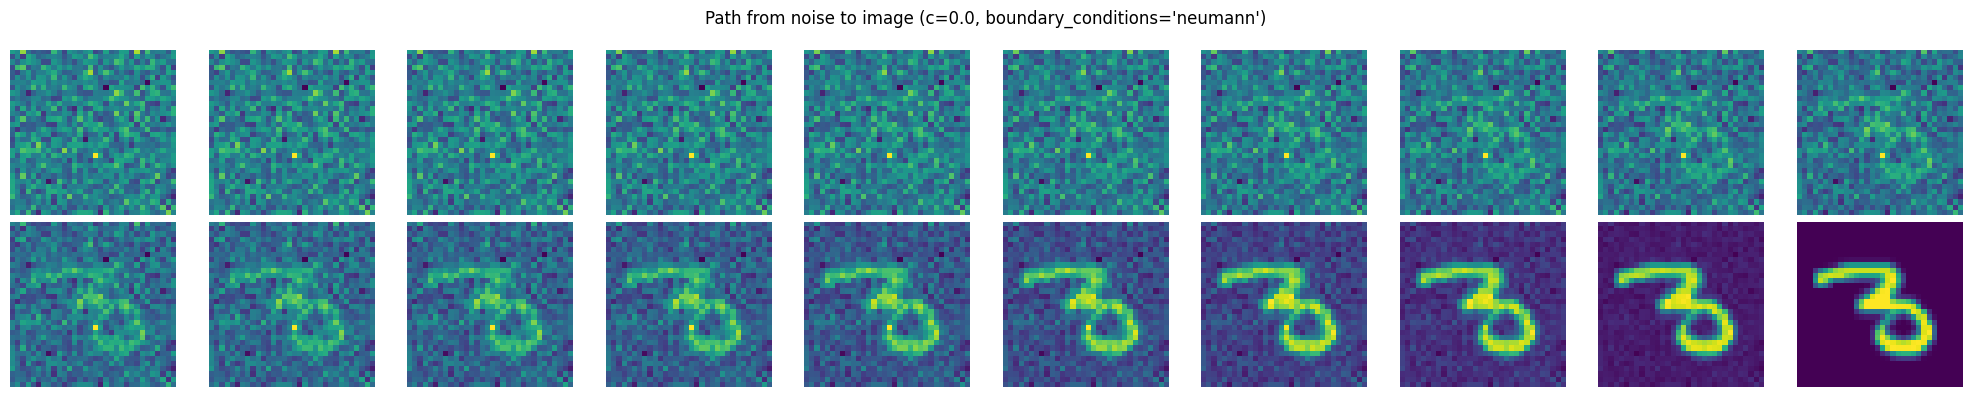

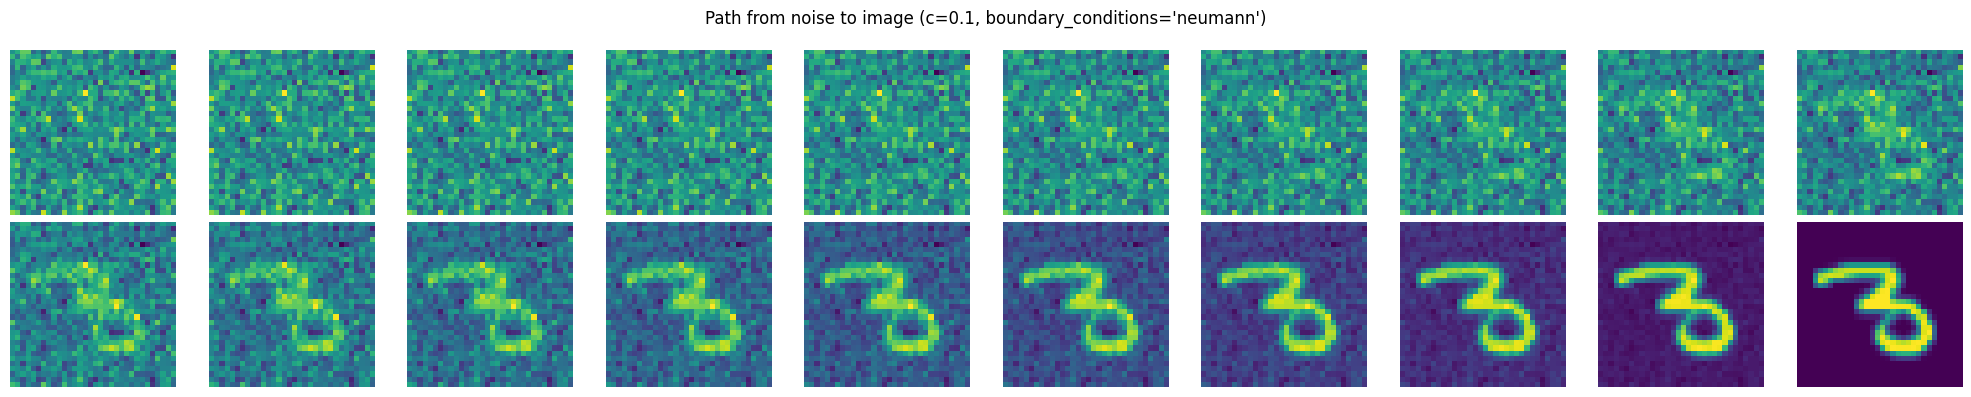

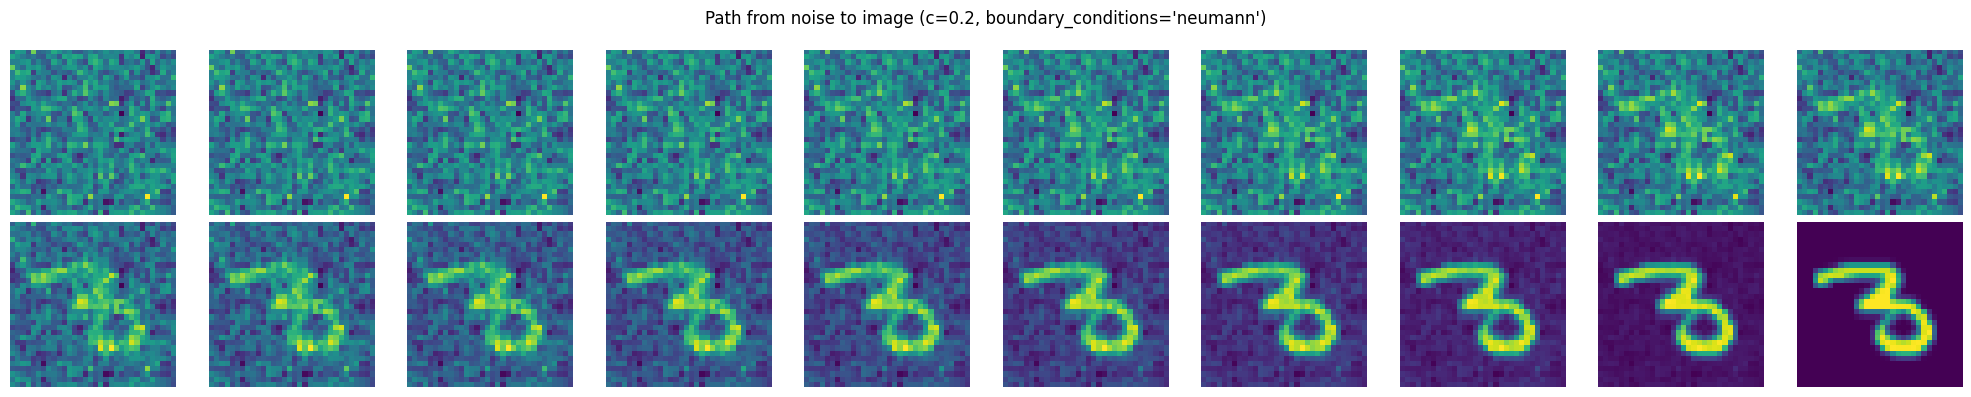

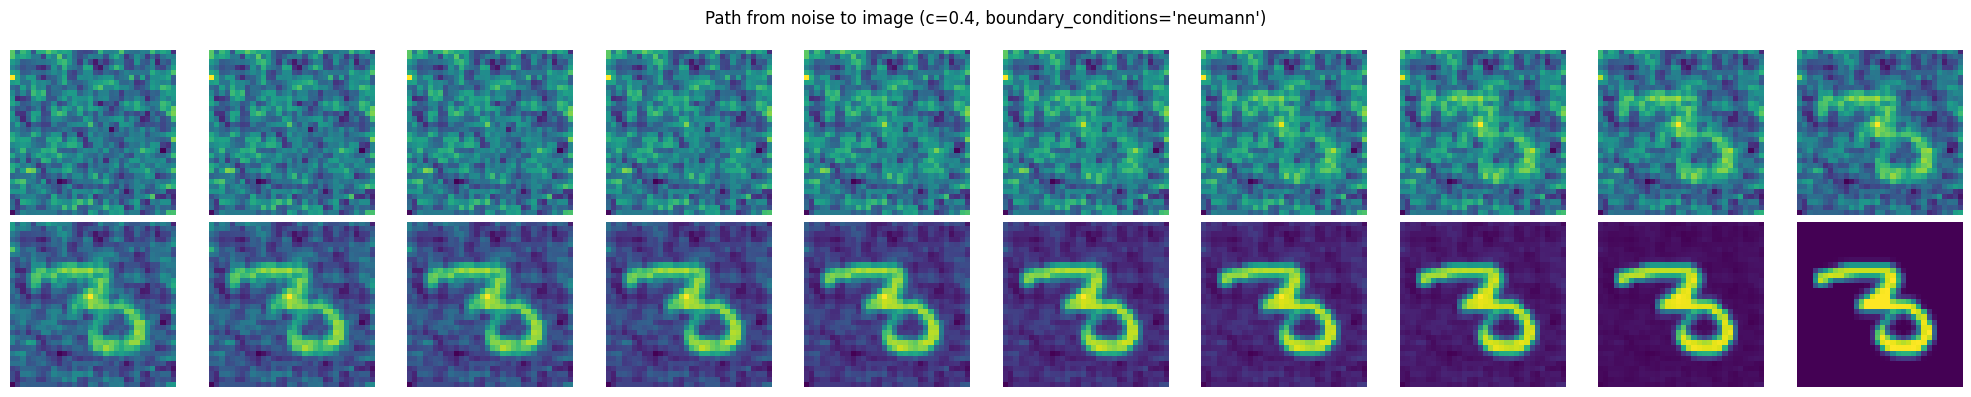

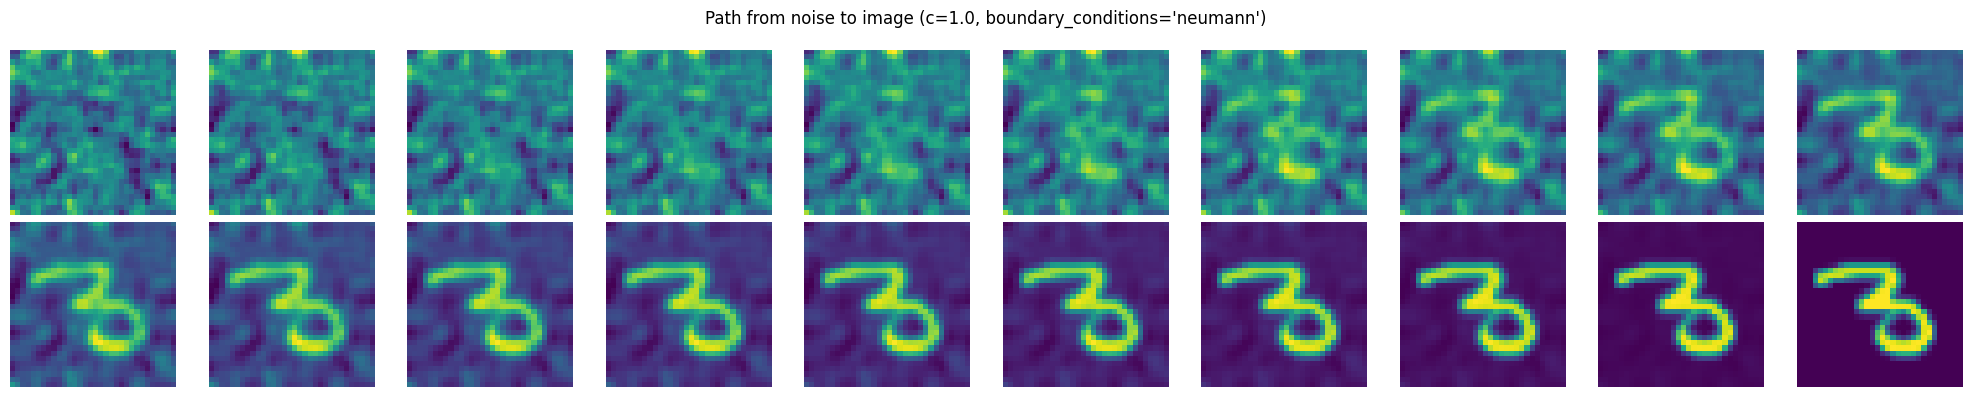

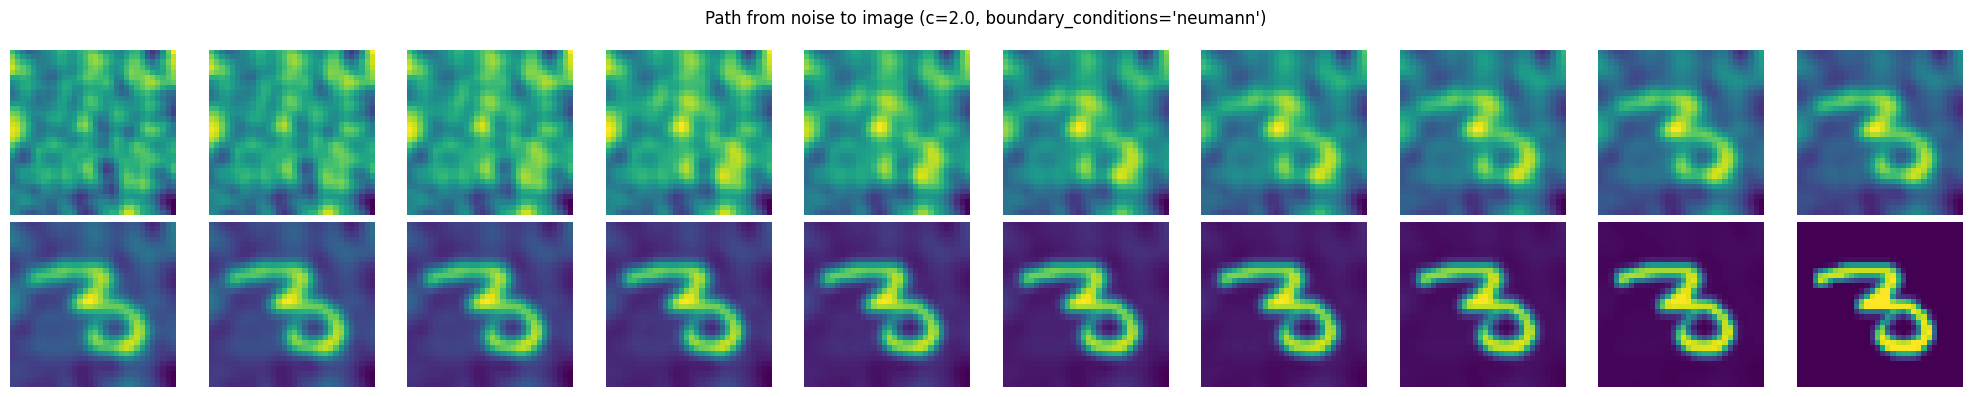

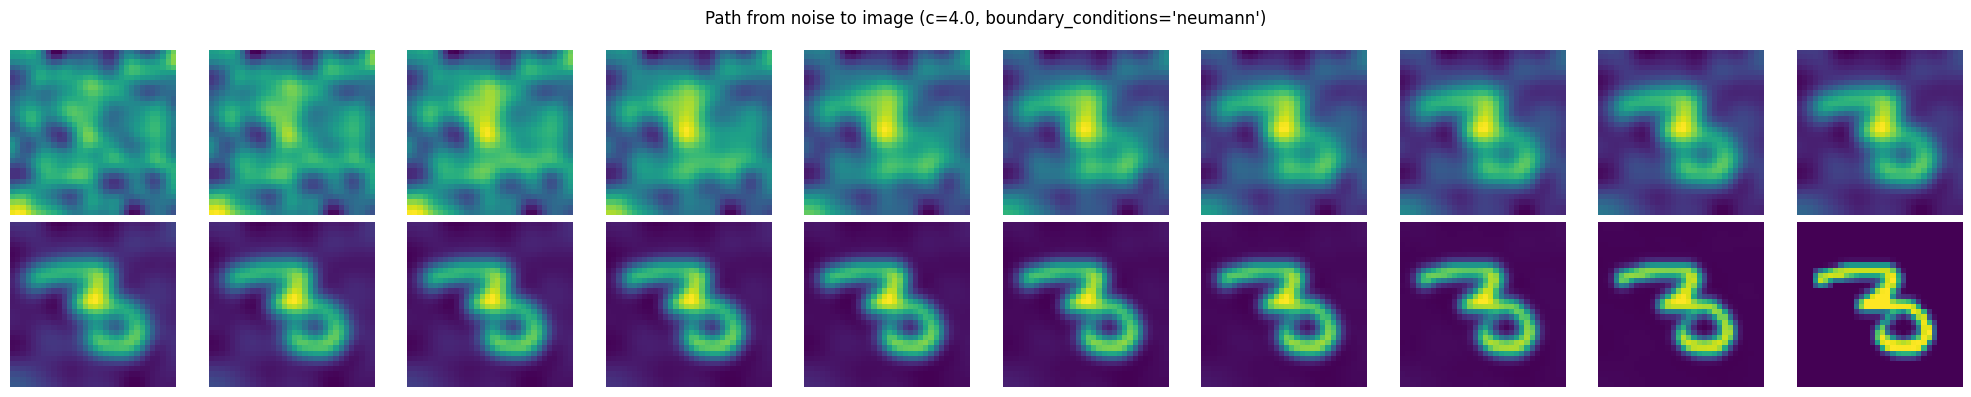

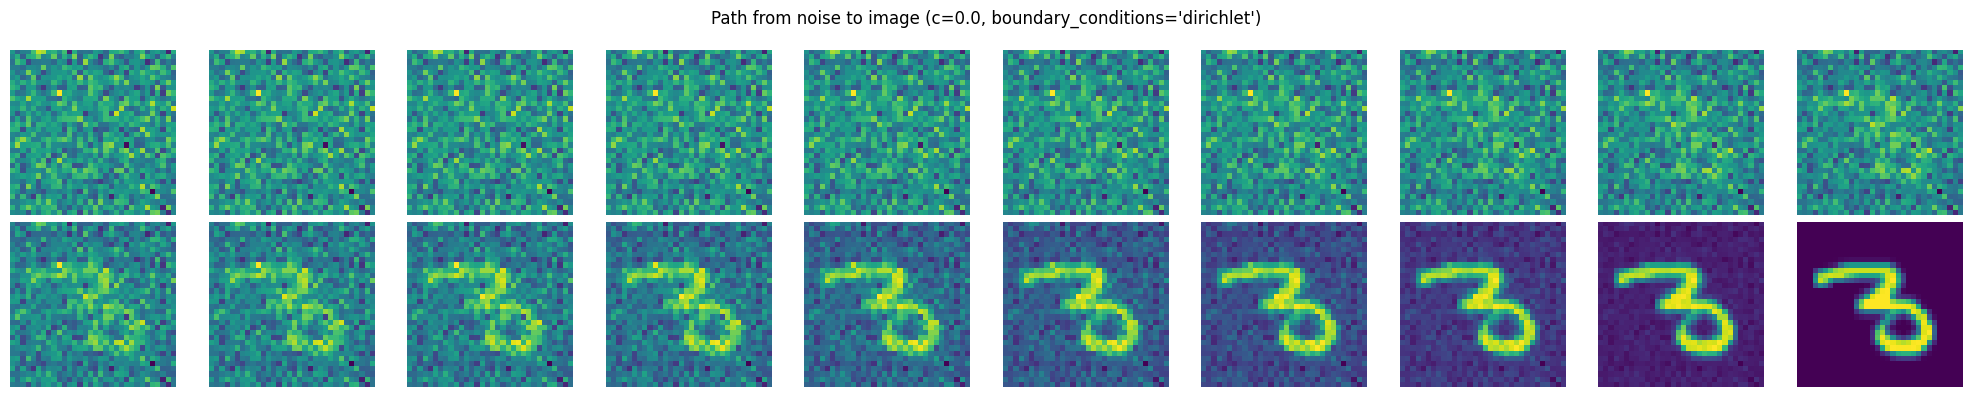

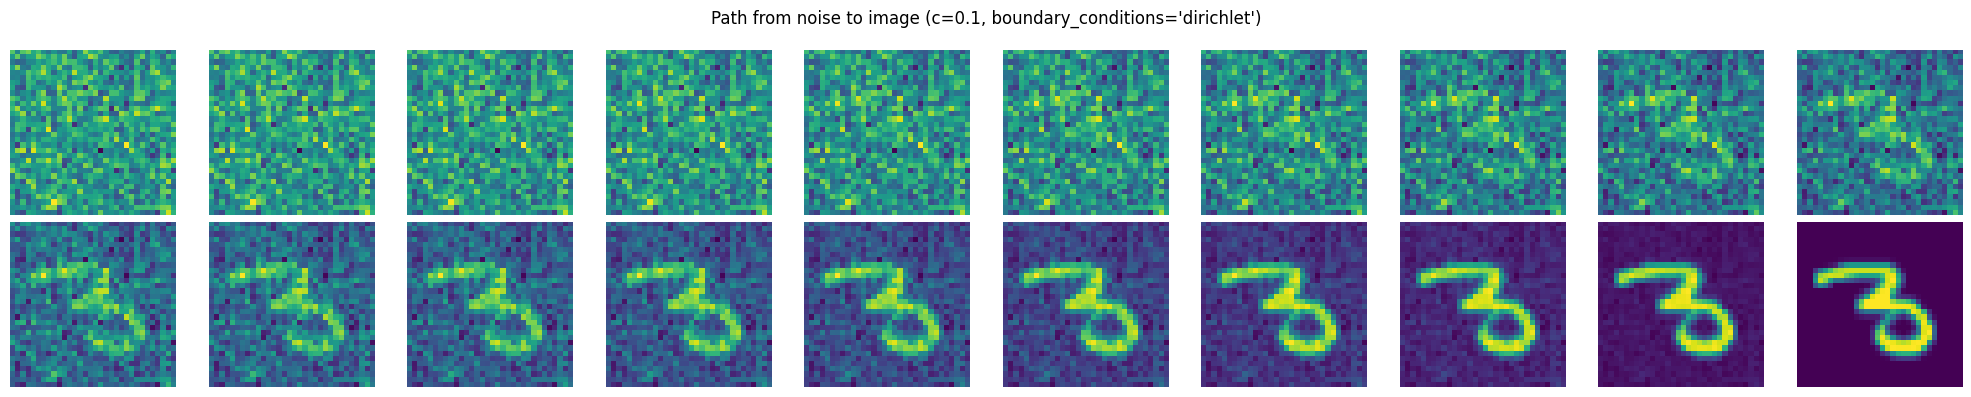

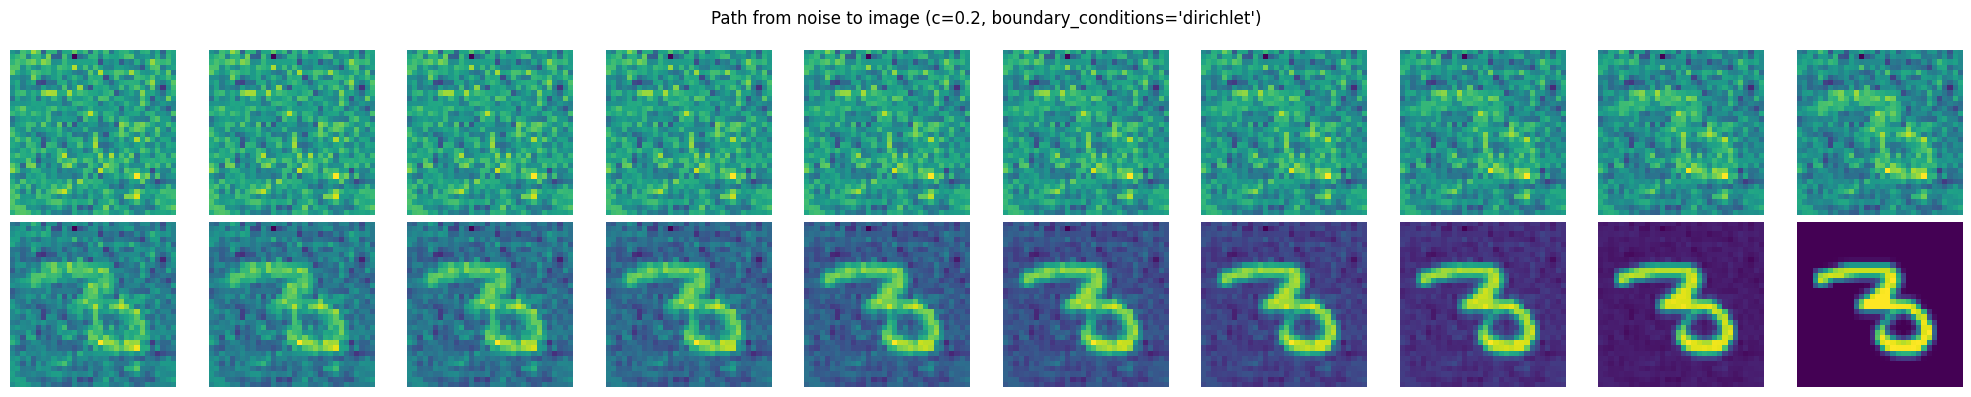

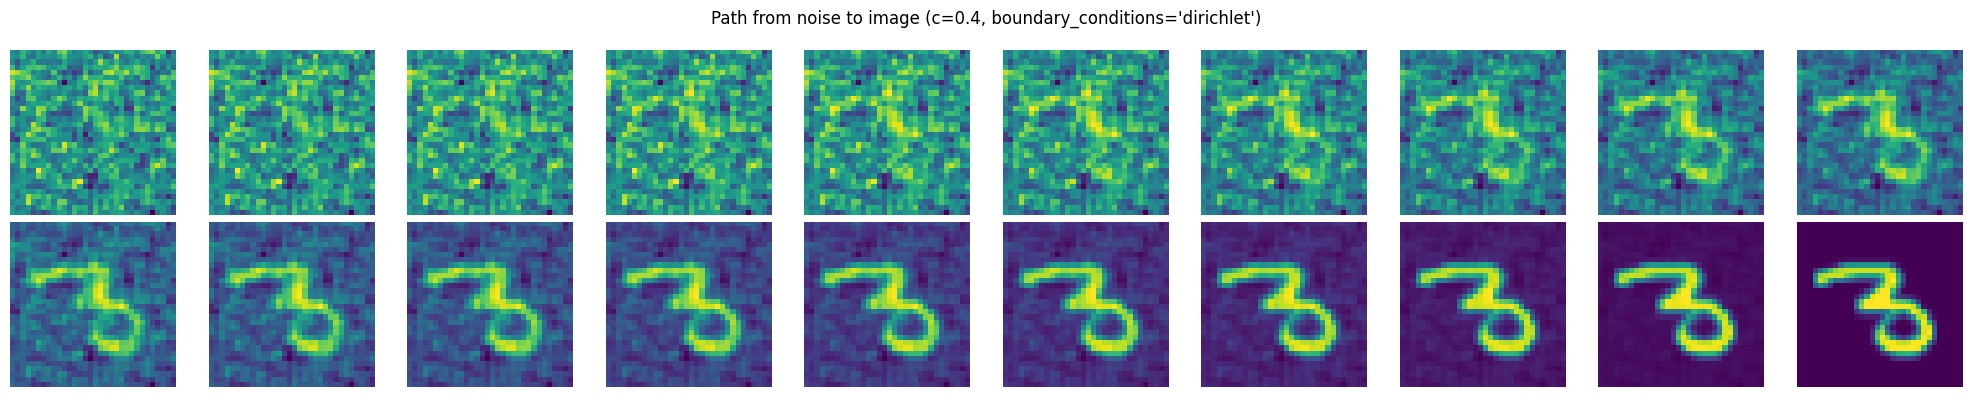

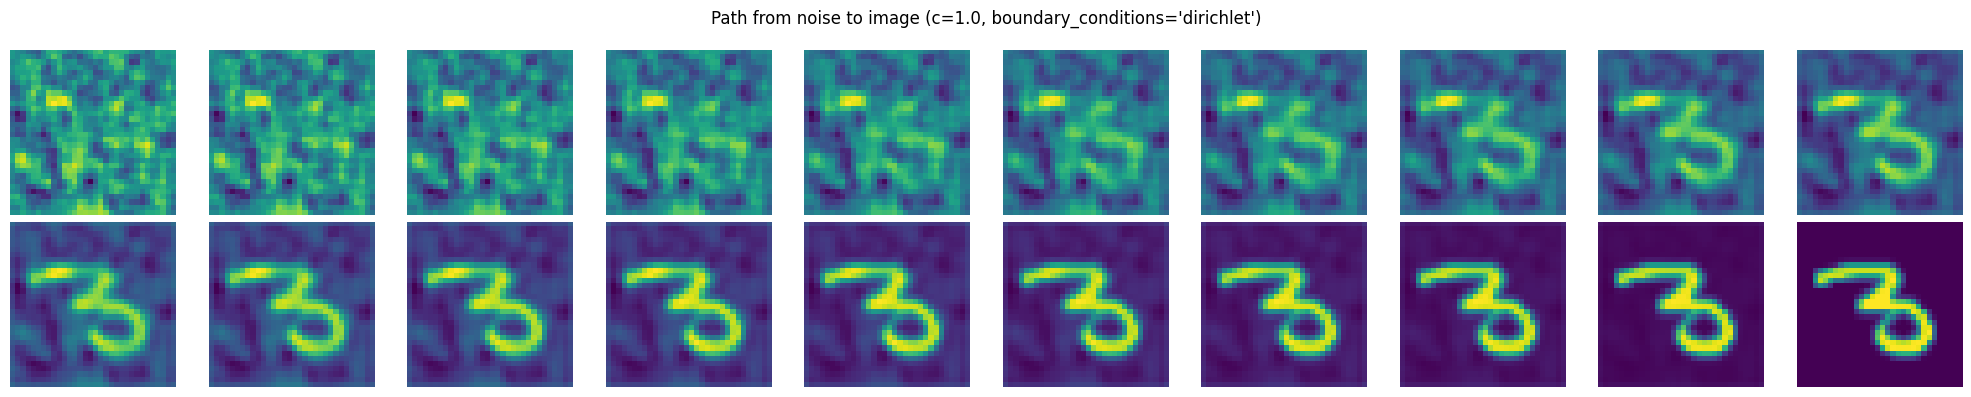

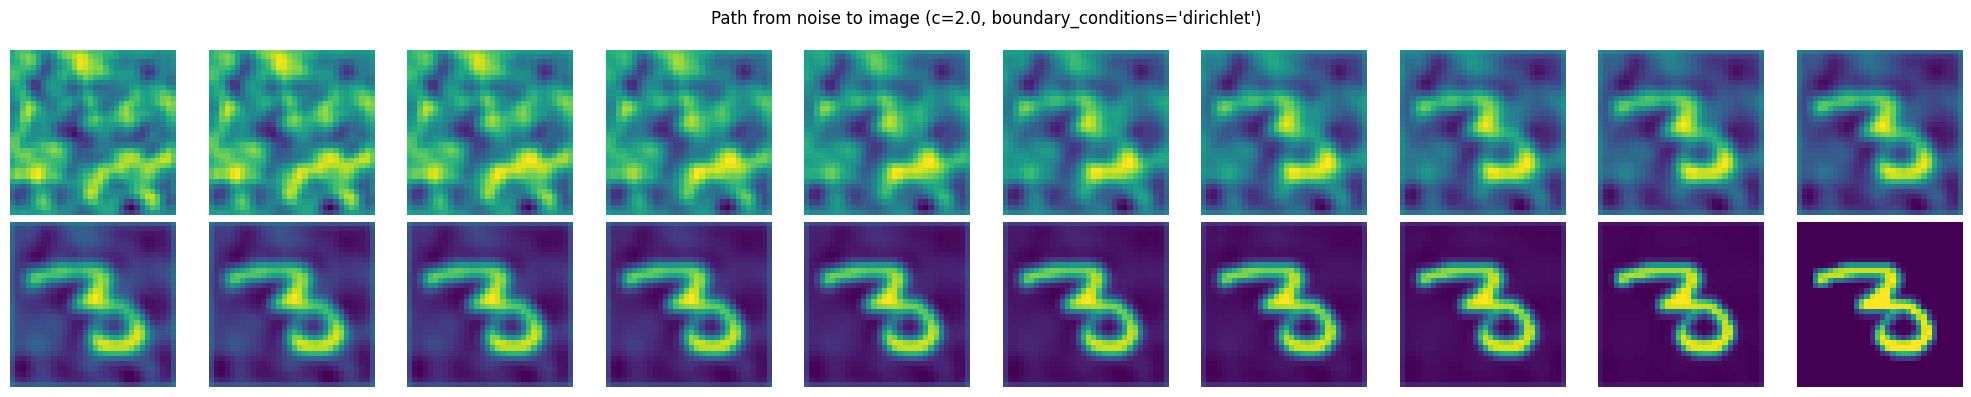

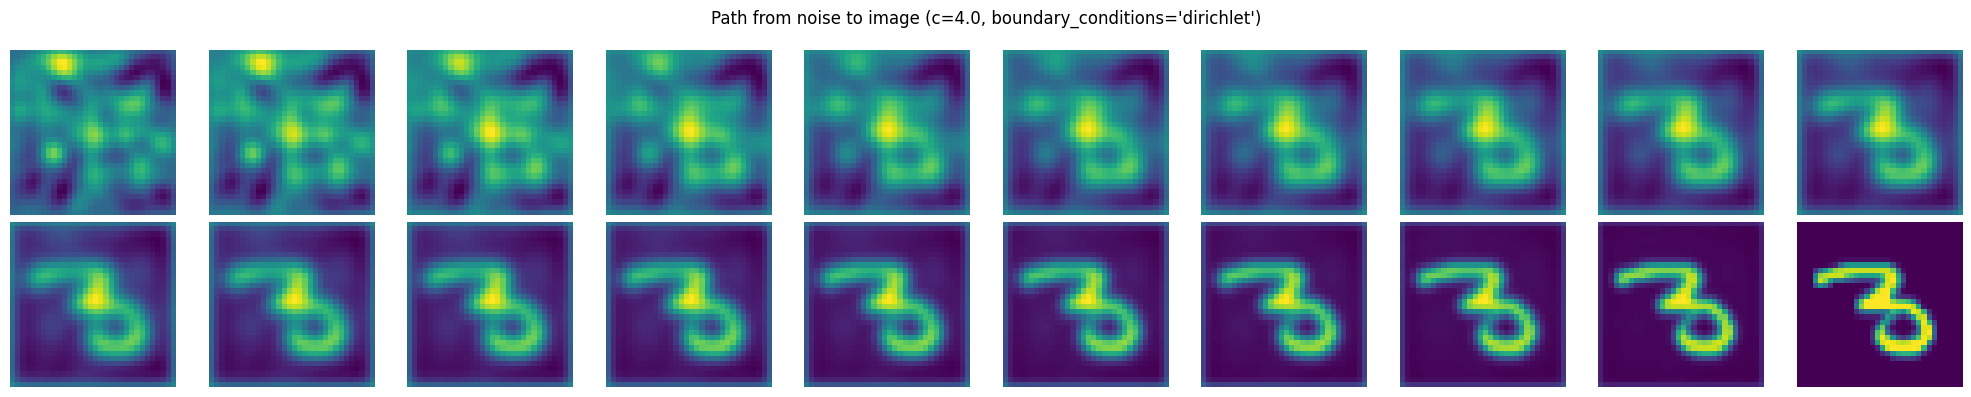

In [20]:
for boundary_conditions in ['neumann', 'dirichlet']:
    for c in [0.0, 0.1, 0.2, 0.4, 1.0, 2.0, 4.0]:
        eigvecs, eigvals = grid_laplacian_eigenpairs((32, 32), boundary_conditions=boundary_conditions)
        ft = NaiveGridFourierTransform((32, 32), eigvecs)
        cfm = ConditionalTopologicalFlowMatcher(c=c, eigenvalues=eigvals, eigenvectors=eigvecs, fourier_transform=ft)
        p0 = build_p0('gp', eigvals, eigvecs, c, (32, 32))

        idx = 30
        x0 = p0.sample()
        x1 = trainset[idx][0][0]
        t = torch.linspace(0.0, 1.0, 1000)

        # spectral computations 
        y0 = ft.transform(x0)
        y1 = ft.transform(x1)
        yt = cfm._bridge_m(y0, y1, t)
        bt = cfm._b(yt, t)
        ut = cfm._bridge_u(y0, y1, t, yt)
        dyt = bt + ut 

        xt, dxt = cfm.ft.inverse_transform(yt), cfm.ft.inverse_transform(dyt)

        xt_pred = euler_method(x0, dxt, t)
        error = torch.norm(xt - xt_pred, dim=-1)

        # Plot 
        num_steps = 20
        nrows = 2
        ncols = num_steps // nrows
        fig, axs = plt.subplots(nrows, ncols, figsize=(20, 4))
        axs = axs.flatten()
        for i in range(num_steps):
            time_idx = i * (len(t) - 1) // (num_steps - 1)
            axs[i].imshow(xt[time_idx].reshape(32, 32))
            axs[i].axis('off')
        plt.suptitle(f'Path from noise to image ({c=}, {boundary_conditions=})')
        plt.tight_layout()
        plt.show()